In [ ]:
# Data Source
# 1. CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html Accessed on 2024 11 11
#   - Files: data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5, test_batch
#   - Renamed to: cifar10-train-1, cifar10-train-2, cifar10-train-3, cifar10-train-4, cifar10-train-5, cifar10-test

# 2. Fashion-MNIST: https://github.com/zalandoresearch/fashion-mnist Accessed on 2024 11 11
#   - Files: train-images-idx3-ubyte, train-labels-idx1-ubyte, t10k-images-idx3-ubyte, t10k-labels-idx1-ubyte
#   - Renamed to: fmnist-train-image, fmnist-train-label, fmnist-test-image, fmnist-test-label

In [ ]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist  # To avoid tensorflow import error for distutils, requires setuptools to be installed
import tensorflow as tf

CIFAR-10
Train Data | Label : (50000, 3072)  |  (50000,)
Test Data | Label : (10000, 3072)  |  (10000,)
Fashion MNIST
Train Data | Label : (60000, 784)  |  (60000,)
Test Data | Label : (10000, 784)  |  (10000,)
CIFAR-10


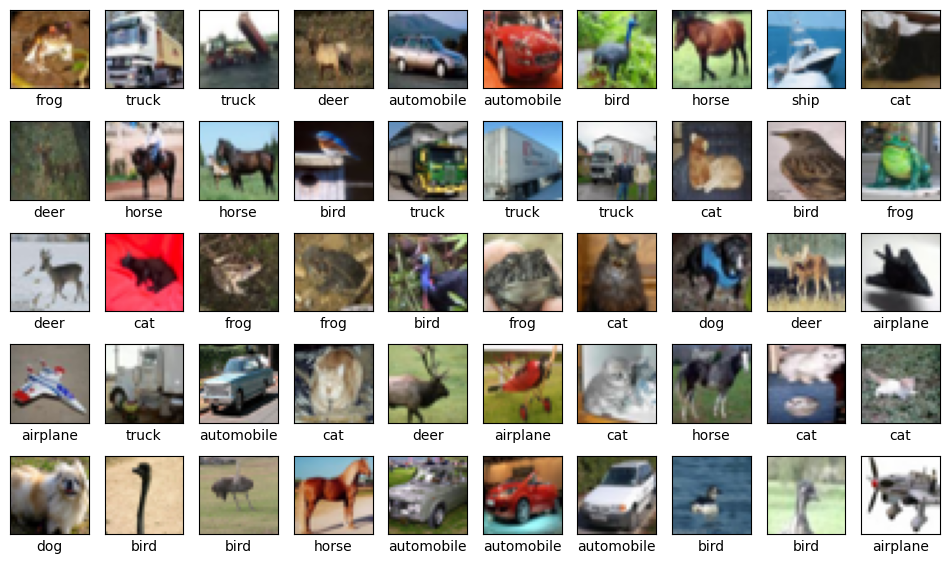

Fashion MNIST


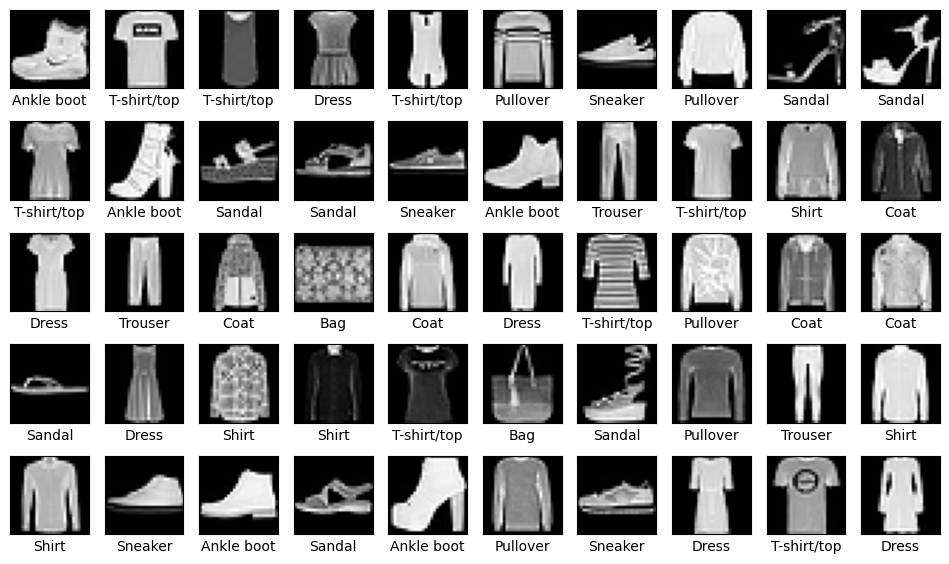

In [37]:
# ==================================================================================================== Step 1. Loading Data
# 1. CIFAR-10 Ref: https://www.cs.toronto.edu/~kriz/cifar.html
# CIFAR-10 Class Label
cifar10_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


# For loading pickle files. From https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


# Data Frame for CIFAR-10
cifar10_train_data = []
cifar10_train_label = []

cifar10_test_data = []
cifar10_test_label = []


# 1.1 Load Train Data
for i in range(1, 6):
    file = f"./data/cifar10-train-{i}"
    cifar10_test_file = unpickle(file)
    cifar10_train_data.append(cifar10_test_file[b"data"])
    cifar10_train_label.append(cifar10_test_file[b"labels"])

cifar10_train_data = np.concatenate(cifar10_train_data)
cifar10_train_label = np.concatenate(cifar10_train_label)


# 1.2 Load Test Data
cifar10_test_file = unpickle("./data/cifar10-test")
cifar10_test_data.append(cifar10_test_file[b"data"])
cifar10_test_label.append(cifar10_test_file[b"labels"])
cifar10_test_data = np.concatenate(cifar10_test_data)
cifar10_test_label = np.concatenate(cifar10_test_label)


# 2. Fashion-MNIST Ref: https://pjreddie.com/projects/mnist-in-csv/ , https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide
# Fashion MNIST Class Label
fmnist_classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


# For converting idx to csv
def idx2csv(image_file, label_file, output_file):
    with open(image_file, "rb") as f:
        image_data = f.read()

    with open(label_file, "rb") as f:
        label_data = f.read()

    # Skip header
    image_data = image_data[16:]
    label_data = label_data[8:]
    image_length = len(image_data) // 784  # 28x28 = 784
    label_length = len(label_data)  # 1 byte per label
    images = np.zeros((image_length, 784), dtype=np.uint8)  # 28x28 = 784
    labels = np.zeros((label_length), dtype=np.uint8)  # 1 byte per label

    # i = image index, j = pixel index
    for i in range(image_length):
        for j in range(784):
            images[i, j] = image_data[i * 784 + j]  # 28x28 = 784

    # i = label index
    for i in range(label_length):
        labels[i] = label_data[i]  # 1 byte per label

    # Save to csv
    np.savetxt(
        output_file,
        np.concatenate((labels.reshape(-1, 1), images), axis=1),
        delimiter=",",
        fmt="%d",
    )


# 2.1 Convert idx to csv
if not os.path.exists("./data/fmnist-train.csv"):
    idx2csv("./data/fmnist-train-image", "./data/fmnist-train-label", "./data/fmnist-train.csv")
if not os.path.exists("./data/fmnist-test.csv"):
    idx2csv("./data/fmnist-test-image", "./data/fmnist-test-label", "./data/fmnist-test.csv")

# 2.2 Load Data
fmnist_train_data = pd.read_csv("./data/fmnist-train.csv", header=None).loc[:, 1:].values
fmnist_train_label = pd.read_csv("./data/fmnist-train.csv", header=None).loc[:, 0].values
fmnist_test_data = pd.read_csv("./data/fmnist-test.csv", header=None).loc[:, 1:].values
fmnist_test_label = pd.read_csv("./data/fmnist-test.csv", header=None).loc[:, 0].values


# 3. Display Data
# 3.1 Display Data Shape
print("CIFAR-10")
print("Train Data | Label :", cifar10_train_data.shape, " | ", cifar10_train_label.shape)
print("Test Data | Label :", cifar10_test_data.shape, " | ", cifar10_test_label.shape)
print("Fashion MNIST")
print("Train Data | Label :", fmnist_train_data.shape, " | ", fmnist_train_label.shape)
print("Test Data | Label :", fmnist_test_data.shape, " | ", fmnist_test_label.shape)

# 3.2 Display image with label and class
# CIFAR-10
print("CIFAR-10")
plt.figure(figsize=(12, 7))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_train_data[i].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.xlabel(cifar10_classes[cifar10_train_label[i]])
plt.show()

# Fashion MNIST
print("Fashion MNIST")
plt.figure(figsize=(12, 7))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist_train_data[i].reshape(28, 28), cmap="gray")
    plt.xlabel(fmnist_classes[fmnist_train_label[i]])
plt.show()

In [ ]:
# ==================================================================================================== Step 2. Data Preprocessing
# 1. CIFAR-10
# 1.1 Normalization
cifar10_train_data_normed = cifar10_train_data / 255.0
cifar10_test_data_normed = cifar10_test_data / 255.0

# 1.2 Reshape
cifar10_train_data_normed = cifar10_train_data_normed.reshape(-1, 32, 32, 3)  # 3 for RGB
cifar10_test_data_normed = cifar10_test_data_normed.reshape(-1, 32, 32, 3)  # 3 for RGB

# 2. Fashion-MNIST
# 2.1 Normalization
fmnist_train_data_normed = fmnist_train_data / 255.0
fmnist_test_data_normed = fmnist_test_data / 255.0

# 2.2 Reshape
fmnist_train_data_normed = fmnist_train_data_normed.reshape(-1, 28, 28, 1)  # 1 for grayscale
fmnist_test_data_normed = fmnist_test_data_normed.reshape(-1, 28, 28, 1)  # 1 for grayscale


# 3. Check data shape before and after normalization
print("CIFAR-10 - Train Original Shape:", cifar10_train_data.shape, " | Normalized Shape:", cifar10_train_data_normed.shape)
print("CIFAR-10 - Test Original Shape:", cifar10_test_data.shape, " | Normalized Shape:", cifar10_test_data_normed.shape)
print("Fashion MNIST - Train Original Shape:", fmnist_train_data.shape, " | Normalized Shape:", fmnist_train_data_normed.shape)
print("Fashion MNIST - Test Original Shape:", fmnist_test_data.shape, " | Normalized Shape:", fmnist_test_data_normed.shape)

# 4. Verify content of data
print("CIFAR-10 - Train Data")
print(cifar10_train_data[1])
print("CIFAR-10 - Train Data Normalized")
print(cifar10_train_data_normed[1])
print("Fashion MNIST - Train Data")
print(fmnist_train_data[1])
print("Fashion MNIST - Train Data Normalized")
print(fmnist_train_data_normed[1])

CIFAR-10 - Train Original Shape: (50000, 3072)  | Normalized Shape: (50000, 32, 32, 3)
CIFAR-10 - Test Original Shape: (10000, 3072)  | Normalized Shape: (10000, 32, 32, 3)
Fashion MNIST - Train Original Shape: (60000, 784)  | Normalized Shape: (60000, 28, 28, 1)
Fashion MNIST - Test Original Shape: (10000, 784)  | Normalized Shape: (10000, 28, 28, 1)
CIFAR-10 - Train Data
[154 126 105 ... 139 142 144]
CIFAR-10 - Train Data Normalized
[[[0.60392157 0.49411765 0.41176471]
  [0.4        0.49019608 0.60784314]
  [0.6745098  0.70588235 0.55686275]
  ...
  [0.34509804 0.40392157 0.36862745]
  [0.25490196 0.3254902  0.35294118]
  [0.30980392 0.26666667 0.2627451 ]]

 [[0.53333333 0.5372549  0.47843137]
  [0.51764706 0.59215686 0.70980392]
  [0.79607843 0.81568627 0.81568627]
  ...
  [0.36078431 0.34509804 0.30588235]
  [0.34117647 0.38431373 0.29803922]
  [0.2627451  0.31764706 0.35686275]]

 [[0.57254902 0.48627451 0.34509804]
  [0.33333333 0.34117647 0.32941176]
  [0.29411765 0.30588235 0.

In [ ]:
# Model architecture
# 1. Basic architecture
# Input Layer > Conv2D > MaxPooling2D > Conv2D > MaxPooling2D > Flatten > Dense > Output Layer

# 2. Model architecture from Kaggle
# CIFAR-10: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer
# Model: Conv2D > Conv2D > MaxPooling2D > Dropout > Conv2D > Conv2D > MaxPooling2D > Dropout > Flatten > Dense > Dropout > Dense

# CIFAR-10: https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy/notebook
# Model: Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Flatten > Dense > BatchNorm > Dropout > Dense

# Fashion MNIST: https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide
# Model: Conv2D > MaxPooling2D > Dropout > Flatten > Dense > Dense

# Fashion MNIST: https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
# Model: Conv2D > conv2D > MaxPooling2D > Flatten > Dense > Dropout > Dense > Dense

# 3. Proposed Model - basic (single model for both CIFAR and Fashion MNIST)
# TODO

# 4. Proposed Model - advanced (single model (with underfitting and overfitting handling) for both CIFAR and Fashion MNIST)
# TODO

# Method for addressing Underfitting and Overfitting
# 1. General: Learning rate, epochs
# 2. Underfitting: Data augmentation (rotation, flip, zoom, shift) 
# 3. Overfitting handling: Dropout, l2 regularization, BatchNormalization

In [ ]:
# ==================================================================================================== Step 3. Model Building
# 1. CIFAR-10
# 1.1 Model Building
